### 사용할 패키지 import

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
from os.path import join
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.cluster import KMeans
from scipy.special import boxcox1p
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import gc

from xgboost import plot_importance

### 데이터 불러오기

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [3]:
train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print(train.head())
print(test.head())

   id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     

###  학습하기 위해 데이터 전처리

#### train data에 결측치 유무 확인
missingo 라이브러리의 matrix함수를 활용, 데이터의 결측 상태를 시각화하여 보여줌

<AxesSubplot:>

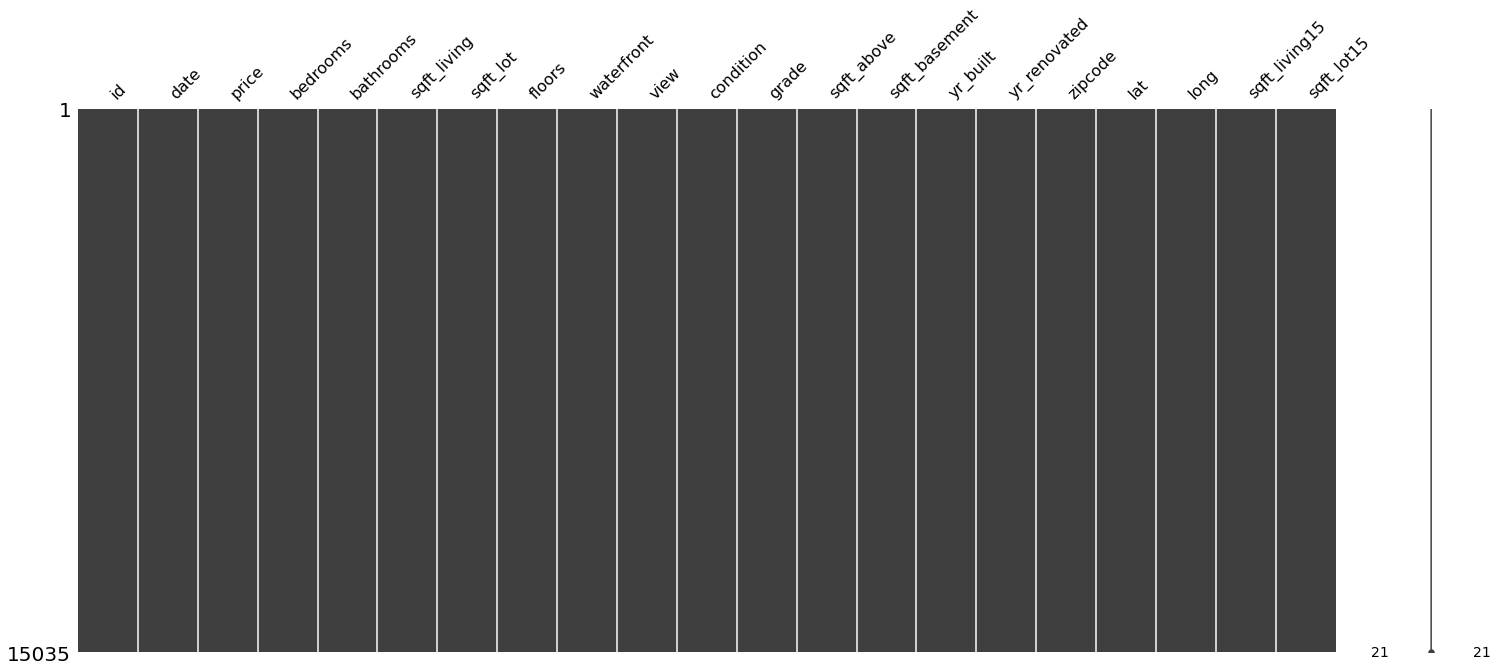

In [4]:
msno.matrix(train)

train data 결측치 상태 유무를 missingo를 활용하여 확인한 결과 해당 특징점에 대하여 결측치가 없는 것으로 나타남<br/>

pandas의 NaN 확인하는 isnull로 다시 한번 더 확인


In [5]:
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


#### train['date'] 불필요한 정보 변경

In [6]:
train['date']

0        20141013T000000
1        20150225T000000
2        20150218T000000
3        20140627T000000
4        20150115T000000
              ...       
15030    20141014T000000
15031    20150326T000000
15032    20140521T000000
15033    20150223T000000
15034    20141015T000000
Name: date, Length: 15035, dtype: object

date의 형태가 현재 yyyy-MM-ddT000000 형태<br/>
price의 가격을 알아볼 때 년/월까지만 있어도 되기 때문에 yyyy-MM까지만 가져오기<br/>
yyyy-mm 형태는 총 6자리로 train['date']에서 처음부터 6자리까지만 불러서 다시 train['date']에 정보를 저장함


In [7]:
# data 전처리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


####  price 정보 확인 및 전처리

In [8]:
train['price']

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Density'>

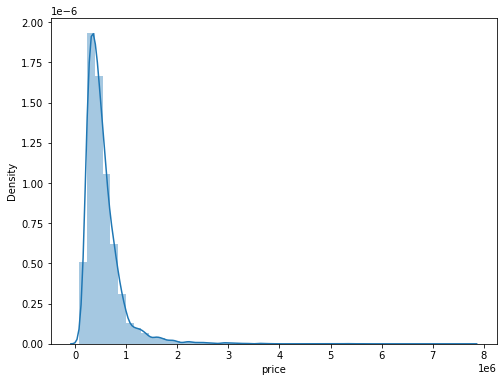

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['price'])

target값인 price의 정보를 기반으로 그래프로 확인한 결과 왼쪽으로 치우침현상이 일어난것을 확인 = skewness(=positive skewness) 왜도 현상을 줄이기 위해 log함수를 사용 참고 https://dining-developer.tistory.com/18

####  target(price)값 log() 형변환

In [10]:
y_log = np.log1p(train['price'])

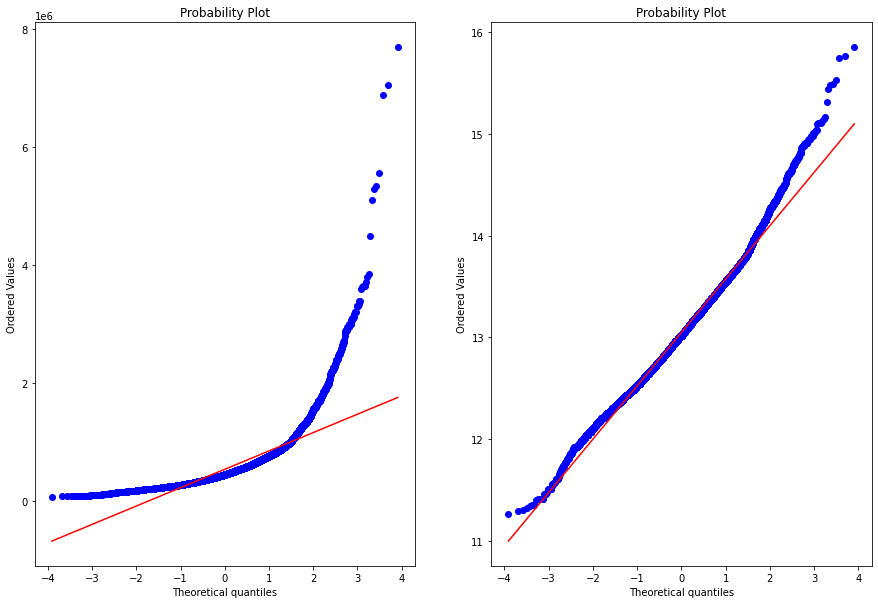

In [11]:
fig = plt.figure(figsize=(15, 10))

fig.add_subplot(1, 2, 1)
res = stats.probplot(train['price'], plot=plt)

fig.add_subplot(1, 2, 2)
res = stats.probplot(y_log, plot=plt)

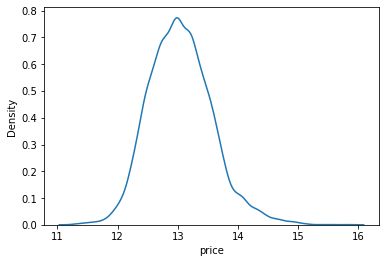

In [12]:
sns.kdeplot(y_log)
plt.show()

그래프로 확인한 결과 target(price) 정보가 log 변환하여 정규화 된것을 확인

In [13]:
train['price'] = np.log1p(train['price'])

log()를 이용하여 정규화한 price 정보를 활용하여 학습하기 위해 다시 train['price']로 정보 변경

In [14]:
train['price']

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

###  이상치 제거

이상치란 다른 데이터보다 아주 작은 값이나 아주 큰 값을 말함
<br/>
이상치를 제거하지 않으면학습하는데 큰 영향력을 줄 수 있기 때문에 제거해주는 것이 좋음

이상치 처리하는 방법은 결측치를 처리하는 방법과 유사
<br/>
1. 제거 : 오타, 오류, 비상식적 반응과 같은 경우 제거
2. 치환: 삭제가 어려운 경우 평균, 최빈값, 중앙값, 예측값 등으로 치환(단, 결측값의 경우와 같은 신뢰도 문제가 발생할 수 있음)
3. 분리: 독립 변수가 충분히 세분화되지 않은 경우 이상치 발생, 이러한 경우 변수를 세분하여 이상치 분리

이상치 분포 확인은 boxplot이 좋음
<br/>
boxplot은 사분위수를 포함하여 최소값, 중앙값, 최대값을 잘 보여줌
<br/>
전체 데이터의 중앙에 해당하는 곳에 중앙값을 먼저 찾고 아래쪽과 위쪽 각각에 다시 중앙값을 찾아 1분위수(Q1), 3분위수(Q3)를 결정

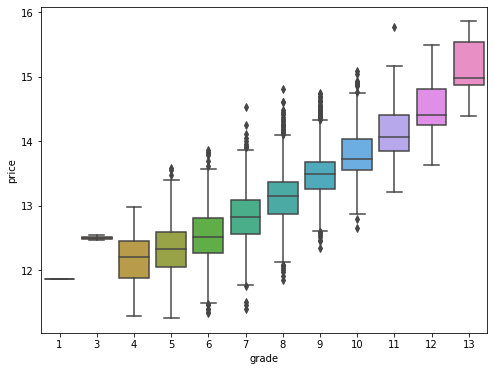

In [15]:
data = pd.concat([train['price'], train['grade']], axis=1)
fig, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y='price', data=data)
# 집 등급에 따른 가격 정보 확인

grade가 8인 경우 price의 정보를 보면 정보가 일정하게 있다가 갑자기 price가 15에 가장 가까이에 있는 값이 존재한다. 이렇듯 다른 값들에 비해 값이 크게 차이나고 있는 것이 이상치이기 때문에 제거가 필요하다.

<br/>
https://blog.naver.com/youz20/222427752870

In [16]:
train.loc[(train['price'] > 12) & (train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,201502,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,201411,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [17]:
train.loc[(train['price'] > 14.7) & (train['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,201408,14.808763,5,4.0,4230,27295,2.0,1,4,...,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [18]:
train.loc[(train['price'] > 15.5) & (train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,201406,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


위의 3가지 정보를 확인
평수 view 등 가격 정하는 부분에 있어 높은 영향을 차지하는 변수와의 관계를 보면
상대적으로 가격이 높은 금액으로 측정되기 때문에 이상치로 판단하여 제거


In [19]:
train = train.loc[train['id'] != 2302]
train = train.loc[train['id'] != 4123]
train = train.loc[train['id'] != 2775]

#### sqft_living(주거 공간에 대한 평방 피트, 면적)에 대한 이상치 확인

price를  측정할 때 가장 큰 요소 중 하나인 sqft_living!!
<br/>
이상치가 있는지 파악하기

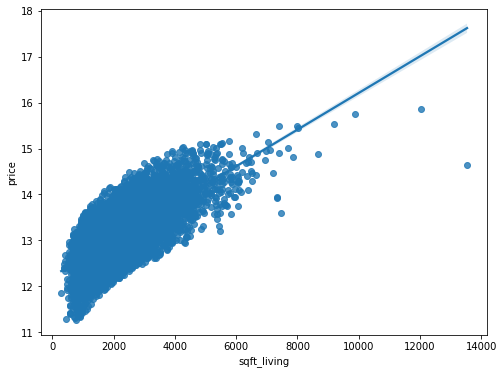

In [20]:
data = pd.concat([train['price'], train['sqft_living']], axis=1)
fig, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y='price', data=data)

sqft_living 정보를 그래프로 확인한 결과 단위 면적 당 가격이 상대적으로 큰 값을 가지는 반면 sqft_living=12000 이상인 경우 면적은 크지만 price 가격은 상대적으로 낮은 값이 나오는 것을 확인
<br/>
해당 데이터만 따로 가져와서 확인

In [21]:
train.loc[train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,201405,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


다른 특정값들을 확인해도 price 가격이 낮은 이유가 없어 이상치로 판단하여 제거

In [22]:
train = train.loc[train['id'] != 8912]

###  변수 정규화 하기

해당 정보가 한쪽으로 치우친 상태에서 학습하게 되면 overfitting에 발생할 확률이 높기 때문에 log()을 활용하여 정규화해주는 것이 좋음

In [23]:
# 정규화
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values) 
    test[c] = np.log1p(test[c].values)

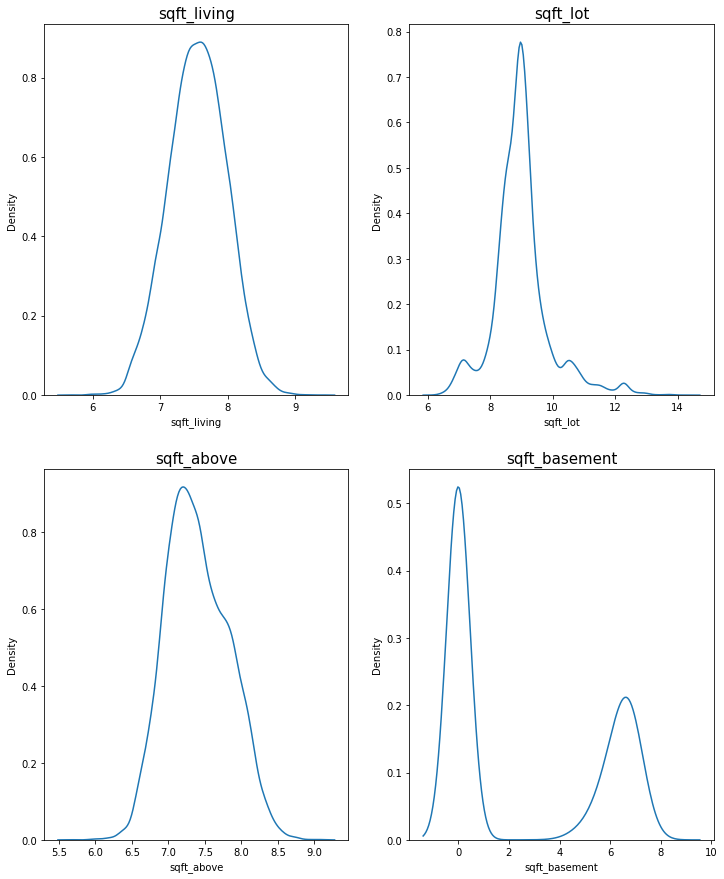

In [24]:
# 변환 후 분포 확인
fig, ax = plt.subplots(2, 2, figsize=(12, 15))

count = 0
for row in range(2):
    for col in range(2):
        if count == 4:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

### 변수 수정

price 가격에 영향을 주는 방, 거실 비율, 재건축 유무에 따라 정보 수정
<br/>
https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12

In [25]:
for df in [train, test]:
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

In [26]:
# 변수 생성
for df in [train, test]:
    # 방의 전체 갯수
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 면적 대비 거실의 비율
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15']
    
    # 재건축 여부
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)

집값의 경우 비슷한 지역에 영향을 받음.
<br/>
주의할 점은 평당 가격을 써야함

In [27]:
# sqft당 가격 정보 변수 생성
train['per_price'] = train['price'] / train['sqft_total_size']
zipcode_price = train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
print(zipcode_price)


    zipcode      mean       var
0     98001  1.490736  0.110772
1     98002  1.559377  0.086592
2     98003  1.426763  0.135985
3     98004  1.427774  0.174133
4     98005  1.307652  0.162820
..      ...       ...       ...
65    98177  1.331077  0.165147
66    98178  1.324285  0.171641
67    98188  1.469849  0.139837
68    98198  1.439939  0.143851
69    98199  1.169488  0.119915

[70 rows x 3 columns]


In [28]:
train = pd.merge(train,zipcode_price,how='left',on='zipcode')
test = pd.merge(test,zipcode_price,how='left',on='zipcode')

In [29]:
# zipcode에 따른 가격정보인 zip_level 변수 생성
a = train[['zipcode', 'price']].groupby('zipcode').mean()
label = [j+1 for j in range(27)]
a['zip_level'] = pd.cut(a.price, bins=27, labels=label)
a = a.drop(['price'], axis=1)

train = train.merge(a, on='zipcode', how='left')
test = test.merge(a, on='zipcode', how='left')
train.zip_level = train.zip_level.astype(int)
test.zip_level = test.zip_level.astype(int)

0.727036944261851


<AxesSubplot:xlabel='zip_level', ylabel='price'>

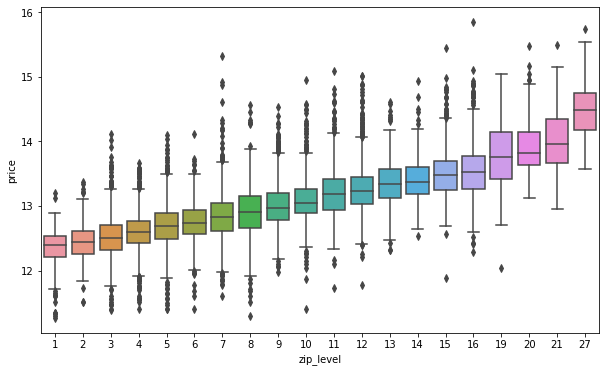

In [30]:
print(train.price.corr(train.zip_level)) # corr() 사용하여 상관관계 분석
fig = plt.figure(figsize=(10, 6))
sns.boxplot(train.zip_level, train.price)


집 등급인 grade를 매기는 기준으로도 여기지는 condition(집의 전박적인 상태), view 값을 합친 새로운 grade 생성

In [31]:
# grade + condition + view 를 합친 새로운 변수 생성
train['new_grade'] = train['grade'] + train['condition'] + train['view']
test['new_grade'] = test['grade'] + test['condition'] + test['view']

In [32]:
for df in [train, test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean']; del df['var']


####  학습에 필요없는 price 제거

In [33]:
# target 분리
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'total_rooms', 'sqft_ratio',
       'sqft_total_size', 'sqft_ratio_1', 'sqft_ratio15', 'is_renovated',
       'per_price', 'zip_level', 'new_grade', 'zipcode_mean', 'zipcode_var'],
      dtype='object')


In [34]:
# id 컬럼 삭제
sub_id = train['id']
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'total_rooms', 'sqft_ratio',
       'sqft_total_size', 'sqft_ratio_1', 'sqft_ratio15', 'is_renovated',
       'per_price', 'zip_level', 'new_grade', 'zipcode_mean', 'zipcode_var'],
      dtype='object')


In [35]:
# test에는 price정보가 없기 때문에 train에서 per_price col 삭제
del train['per_price']

In [36]:
# test 데이터 처리
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'total_rooms', 'sqft_ratio',
       'sqft_total_size', 'sqft_ratio_1', 'sqft_ratio15', 'is_renovated',
       'zip_level', 'new_grade', 'zipcode_mean', 'zipcode_var'],
      dtype='object')


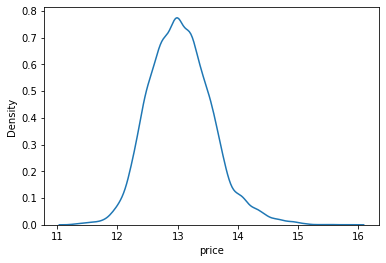

In [37]:
# y분포 확인
sns.kdeplot(y)
plt.show()

In [38]:
# train 전체 자료형 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15031 entries, 0 to 15030
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             15031 non-null  int64  
 1   bedrooms         15031 non-null  int64  
 2   bathrooms        15031 non-null  float64
 3   sqft_living      15031 non-null  float64
 4   sqft_lot         15031 non-null  float64
 5   floors           15031 non-null  float64
 6   waterfront       15031 non-null  int64  
 7   view             15031 non-null  int64  
 8   condition        15031 non-null  int64  
 9   grade            15031 non-null  int64  
 10  sqft_above       15031 non-null  float64
 11  sqft_basement    15031 non-null  float64
 12  yr_built         15031 non-null  int64  
 13  yr_renovated     15031 non-null  float64
 14  zipcode          15031 non-null  int64  
 15  lat              15031 non-null  float64
 16  long             15031 non-null  float64
 17  sqft_living1

In [39]:
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated,zip_level,new_grade,zipcode_mean,zipcode_var
0,201410,3,1.00,7.074117,8.639588,1.0,0,0,3,7,...,4.00,0.818803,7.074117,1.0,0.237168,0,3,10,9.368147,1.214207
1,201502,2,1.00,6.647688,9.210440,1.0,0,0,3,6,...,3.00,0.721756,6.647688,1.0,0.337385,0,9,9,9.257745,1.023549
2,201502,3,2.00,7.427144,8.997271,1.0,0,0,3,8,...,5.00,0.825489,7.427144,1.0,0.239904,0,14,11,11.307711,0.826257
3,201406,3,2.25,7.447751,8.827615,2.0,0,0,3,7,...,5.25,0.843688,7.447751,1.0,0.328201,0,3,10,10.626177,1.012780
4,201501,3,1.50,6.966967,9.181118,1.0,0,0,3,7,...,4.50,0.758837,6.966967,1.0,0.169910,0,3,10,10.032009,1.002206


In [40]:
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated,zip_level,new_grade,zipcode_mean,zipcode_var
0,201412,3,2.25,7.852050,8.887791,2.0,0,0,3,7,...,5.25,0.883465,13.676905,0.574110,0.221233,1,9,10,19.243241,2.317027
1,201412,4,3.00,7.581210,8.517393,1.0,0,0,5,7,...,7.00,0.890086,13.772040,0.550478,0.272000,0,11,12,18.113257,2.389816
2,201405,4,4.50,8.598036,11.532051,1.0,0,0,3,11,...,8.50,0.745577,15.600098,0.551153,0.046699,0,13,14,25.917920,0.737584
3,201504,3,1.00,7.484930,8.918784,1.0,0,0,3,7,...,4.00,0.839232,13.551911,0.552315,0.219401,0,5,10,19.759625,2.053191
4,201503,3,2.50,7.544861,8.788898,2.0,0,0,3,7,...,5.50,0.858454,7.544861,1.000000,0.315720,0,6,10,11.947244,0.477170


#### 학습 시키기 위해 필요한 모델 import

In [41]:
# 모듈 import
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error # RMSE 계산을 위해 가져옴

In [42]:
# rmse 함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

대회에서 점수를 매기는 것과 같은 평가 척도인 RMSE를  계산하기 위해 y_test나 y_pred는 np.log1p()로 변환된 값이기 때문에 원래 데이터의 단위에 맞게 되돌리는 np.expm1()을 추가해야함

In [43]:
# 모델 import
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [44]:
# 스코어 계산 함수
def get_scores(models, train, y):
        df = {}

        for model in models:
            model_name = model.__class__.__name__
            X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            if model_name in df:
                model_name = model_name + str(models.index(model))
            df[model_name] = rmse(y_test, y_pred)
            score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
        return (score_df)     

In [45]:
# 그리드 탐색
from sklearn.model_selection import GridSearchCV

In [46]:
# GridSearch 함수 선언
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid,
                            scoring='neg_root_mean_squared_error',
                            cv=5, verbose=verbose, n_jobs=n_jobs)
    grid_model.fit(train, y)
    grid_model.cv_results_

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['score'] = score

    results['RMSLE'] = -1 * results['score']
    results = results.sort_values(['RMSLE'])

    return results

In [47]:
# save_submission 함수 선언
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    
    prediction = model.predict(test)
    prediction = prediction
    
    data_dir = './data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    
    submission['price'] = np.expm1(prediction)
    
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [48]:
random_state=2020   

모델 파라미터 초기화나 데이터 구성에 사용되는 random_seate값은 특정 값이나 None을 세팅할 수 있음
<br/>
random_state를 고정값으로 주면 모델과 데이터셋이 동일한 경우 머신러닝 학습 결과도 항상 동일하게 재현됨

In [49]:
# save_submission 함수 선언
def save_model(y_pred, model_name, rmsle=None):
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    
    submission['price'] = np.expm1(y_pred)
    
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

#### 모델 별 설명

#### GradientBoostingRegressor

이진 트리의 오파를 보완하는 방법 (random froest를 개선하는 방법)<br/>
특징<br/>
강력한 가지치기, 트리의 깊이가 깊지 않음, 무작위성 없음, 매개변수 조절하기 어려움

인자 결정<br/>
n_estimator: 트리의 수
max_depth: 트리의 깊이
max_features: 나누는 수
learning rate: 학습률

#### XGBRegressor
약한 분류기를 세트로 묶어 정확도를 예측하는 기법 Greedy ALgorithm을 사용, 분류기를 발견하고 분산처리를 사용하여 빠른 속도로 적합한 비중 파라미터 찾는 알고리즘 boostin 알고리즘의 원리
참고: https://riverzayden.tistory.com/17

장점
병렬처리를 사용하기에 학습과 분류가 빠름 유연성이 좋음, 다른 알고리즘과 연계하여 앙상블 학습 가능
https://riverzayden.tistory.com/17

learning_rate: 기본값 0.3, 같이 높을수록 과적합되기 쉬움
n_estimators: 학습 횟수,기본값: 100, learning_rate 낮을 때 n_estimators 높여야 과적합 방지
max_depth: 트리의 max depth, 기본값: 6, 적절한 값 제시되어야 함, 보통 3~10사이 적용
min_child_weight: 기본값 1, 관측치에 대한 가중치 합의 최소, 

#### LGBMRegressor
Gradient Boosting 프레임워크로 Tree 기반 학습 알고리즘
속도가 빠르며 큰 사이즈의 데이터를 다룰 수 있고 실행시킬 때 적은 메모리를 차지

파라미터 튜닝
num_leaves: Tree 모델의 복잡성을 컨트롤하는 주요 파라미터 이상적으로 num_leaves값은 2^max_depth 값보다 적거나 같아야함
min_data_in_leaf: 큰 값으로 세팅 시 tree가 너무 깊게 확장되는 것을 막을 수 있지만 under-fitting 발생할 수 있음
max_depth: tree깊이를 명확하게 제한하기 위해 설정
참

#### RandomForestRegressor
데이터셋의 다양한 하위 샘플 이용해서 분류 의사 결정 트리를 학습

n_estimators: 포레스트 트리 수, 디폴트 =10
criterion: 분할된 것의 품질을 측정하는 기능 mse(mean sqared error) or mae(mean absolute error)
random_state: bootstrap=true인 경우 트리를 만들때 사용하는 샘플의 부트스트래핑 무작위성, 각 노드에서 최고의 분할을 찾을 때 고여해야하는 특성의 샘플 모두 조정, default=none
참고: https://m.post.naver.com/viewer/postView.naver?volumeNo=28037302&memberNo=18071586

#### GridSearch 필요한 param_grid 설정 및 실행

In [50]:
# 탐색할 parameter 준비
param_grid = {
    'boosting' : ['goss'],
    'n_estimators': [1400, 1600, 2000],
    'max_depth': [5, 7, 9, 11, 13],
    'learning_rate': [0.015, 0.018, 0.021, 0.024]
    #'num_leaves' : [127, 255, 511]
}

In [51]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.015, max_depth=5, n_estimators=1400; total time=   3.6s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.015, max_depth=5, n_estimators=1400; total time=   3.7s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.015, max_depth=5, n_estimators=1600; total time=   6.0s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.015, max_depth=5, n_estimators=1600; total time=   4.6s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boost

,boosting,learning_rate,max_depth,n_estimators,score,RMSLE
17,goss,0.018,5,2000,-0.159039,0.159039
16,goss,0.018,5,1600,-0.159126,0.159126
18,goss,0.018,7,1400,-0.159127,0.159127
12,goss,0.015,13,1400,-0.159266,0.159266
19,goss,0.018,7,1600,-0.159285,0.159285
15,goss,0.018,5,1400,-0.159309,0.159309
13,goss,0.015,13,1600,-0.159338,0.159338
6,goss,0.015,9,1400,-0.159412,0.159412
7,goss,0.015,9,1600,-0.159432,0.159432
21,goss,0.018,9,1400,-0.159523,0.159523


In [52]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 2,4],
    'learning_rate':[0.0001, 0.001, 0.1]
}

model = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
17,0.1000,4,100,-0.167718,0.167718
16,0.1000,4,50,-0.175509,0.175509
15,0.1000,2,100,-0.183282,0.183282
14,0.1000,2,50,-0.201032,0.201032
13,0.1000,1,100,-0.205566,0.205566
12,0.1000,1,50,-0.236278,0.236278
11,0.0010,4,100,-0.489693,0.489693
9,0.0010,2,100,-0.497853,0.497853
10,0.0010,4,50,-0.507859,0.507859
7,0.0010,1,100,-0.509255,0.509255


In [53]:
### 그리드 탐색  적용
param_grid = {
    'n_estimators': [5,10,20,50], # 포레스트에서 트리의 수
    'max_features': [2,4,6,8], 
    'bootstrap':[False],
    
}

model = RandomForestRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,bootstrap,max_features,n_estimators,score,RMSLE
15,False,8,50,-0.171666,0.171666
11,False,6,50,-0.172174,0.172174
7,False,4,50,-0.174811,0.174811
14,False,8,20,-0.175575,0.175575
10,False,6,20,-0.175681,0.175681
6,False,4,20,-0.179506,0.179506
13,False,8,10,-0.181085,0.181085
3,False,2,50,-0.181612,0.181612
9,False,6,10,-0.182081,0.182081
5,False,4,10,-0.186630,0.186630


#### GridSearch로 찾은 값 활용하여 모델 구성

In [54]:
lightgbm = LGBMRegressor(boosting='goss', learning_rate=0.018, max_depth=5, n_estimators=2000, random_state=random_state)

In [55]:
rdforest = RandomForestRegressor(max_features=8, n_estimators=50, bootstrap=False,random_state=random_state)

In [56]:
gboost_model = GradientBoostingRegressor(learning_rate=0.1,max_depth=4,n_estimators=100, random_state=random_state)

#### model Blending 하여 score 값 확인

In [57]:
get_scores([lightgbm, rdforest, gboost_model], train, y)

,RMSE
RandomForestRegressor,119001.122401
GradientBoostingRegressor,115167.936148
LGBMRegressor,107382.642905


Blending기법을 활용하여 총 3가지 모델의 score 값을 확인한 결과 LGBMRegressor 값이 가장 좋은 결과가 나왔다.
<br/>
LGBMRegressor 활용하여 최종 submission 만듦

#### LGBMRegressor 활용 최종 submission 만들기

In [60]:
save_submission(lightgbm, train, y, test, "LGBM", 0.159039)

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
./data/submission_LGBM_RMSLE_0.159039.csv saved!


####  Kaggle Submmit 최종 score

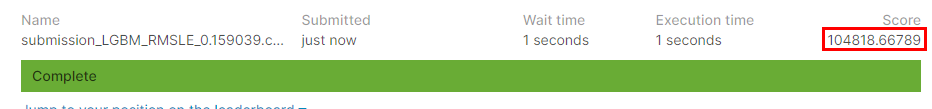

In [61]:
from IPython.display import Image
img_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
Image(img_dir+'/final_score.png')

###  Kaggle 진행하면서 느낀점

이번 2019-ml-month-2nd-baseline 진행하면서 생각보다 과정이 많아 원하는 score 값까지 가는 과정이 힘들었다.
특히 이상치 부분은 처음 모델을 구성할 때 생각도 못한 부분이여서 많은 것을 깨달았다.
(추후 이상치부분 판단 및 확인하는 방법에 대하여 추가적으로 공부 할 예정)

GridSearch 부분은 해당 model에 따라 parameter가 다르며 수도 많이 있기 때문에
필요한 parameter만 가져오는 것이 쉽지가 않아 생각보다 시간이 오래 걸렸다.

Blending 또한 처음으로 접한 부분이여서 이해하는 단계만 3일 이상 걸렸다....

앞으로 다른 문제들 또한 Blending 기법을 활용하여 model을 비교하여 사용하여 score값을 최대한 개선하면서 최종 model을 추출하고자 한다.